#Memasukan dataset dan menampilkan

In [ ]:
import pandas as pd

# Path ke file CSV
data = 'data.csv'

# Membaca dataset CSV menjadi DataFrame
df = pd.read_csv(data)

# Menampilkan dari dataset
print(df)

       event_id_cnty  event_date  year  time_precision  \
0           PSE62716  2024-11-01  2024               1   
1           YEM93235  2024-11-01  2024               1   
2           YEM93304  2024-11-01  2024               1   
3           YEM93309  2024-11-01  2024               1   
4           YEM93315  2024-11-01  2024               1   
...              ...         ...   ...             ...   
476224      YEM32562  2015-01-01  2015               1   
476225      YEM32563  2015-01-01  2015               1   
476226      YEM32564  2015-01-01  2015               1   
476227      YEM32559  2015-01-01  2015               1   
476228      YEM32560  2015-01-01  2015               1   

                 disorder_type                  event_type  \
0       Strategic developments      Strategic developments   
1               Demonstrations                    Protests   
2               Demonstrations                    Protests   
3               Demonstrations                    Prote

#Cleaning Data

In [ ]:
import pandas as pd

# Fungsi untuk membersihkan data
def clean_data(df):
    # Menghapus kolom yang tidak relevan atau memiliki banyak nilai null
    columns_to_drop = ['assoc_actor_1', 'tags']
    df = df.drop(columns=columns_to_drop, errors='ignore')

    # Menangani missing values dengan mengganti nilai kosong
    df = df.fillna({'fatalities': 0, 'source': 'Unknown', 'source_scale': 'Unknown'})

    # Memastikan kolom 'year' dan 'fatalities' dalam format numerik
    df['year'] = pd.to_numeric(df['year'], errors='coerce')
    df['fatalities'] = pd.to_numeric(df['fatalities'], errors='coerce')

    # Menghapus baris dengan nilai 'year' atau 'fatalities' yang tidak valid
    df = df.dropna(subset=['year', 'fatalities'])

    # Menghapus duplikasi data
    df = df.drop_duplicates()

    # Menghapus spasi tambahan di nama kolom
    df.columns = df.columns.str.strip()

    # Merapikan format kolom teks (contoh: menghapus spasi tambahan)
    df['notes'] = df['notes'].str.strip()

    return df

# Membersihkan DataFrame langsung
df = clean_data(df)

print(df)

       event_id_cnty  event_date  year  time_precision  \
0           PSE62716  2024-11-01  2024               1   
1           YEM93235  2024-11-01  2024               1   
2           YEM93304  2024-11-01  2024               1   
3           YEM93309  2024-11-01  2024               1   
4           YEM93315  2024-11-01  2024               1   
...              ...         ...   ...             ...   
476224      YEM32562  2015-01-01  2015               1   
476225      YEM32563  2015-01-01  2015               1   
476226      YEM32564  2015-01-01  2015               1   
476227      YEM32559  2015-01-01  2015               1   
476228      YEM32560  2015-01-01  2015               1   

                 disorder_type                  event_type  \
0       Strategic developments      Strategic developments   
1               Demonstrations                    Protests   
2               Demonstrations                    Protests   
3               Demonstrations                    Prote

#Standarisasi

In [ ]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, when, lower, trim
from pyspark.sql.types import IntegerType, DoubleType, StringType

# Inisialisasi SparkSession
spark = SparkSession.builder.appName("DataCleaning").getOrCreate()

# Path file CSV
file_path = "data.csv"  # Ganti dengan path file CSV Anda

# Baca data dari CSV ke DataFrame
df = spark.read.csv(file_path, header=True, inferSchema=True)

# 1. Perbaiki masalah encoding pada kolom teks (contoh penggantian khusus untuk data ini)
df = df.withColumn("actor1", when(col("actor1").contains("Ã¼"), "ü").otherwise(col("actor1"))) \
       .withColumn("source", when(col("source").contains("Ã©"), "é").otherwise(col("source")))

# 2. Gantilah nilai NaN/None pada kolom numerik dengan nilai default (0 atau rata-rata)
df = df.fillna({
    "latitude": 0.0,
    "longitude": 0.0,
    "fatalities": 0,
    "year": 0,
    "time_precision": 0
})

# 3. Konversikan kolom numerik menjadi tipe yang sesuai
df = df.withColumn("latitude", col("latitude").cast(DoubleType())) \
       .withColumn("longitude", col("longitude").cast(DoubleType())) \
       .withColumn("fatalities", col("fatalities").cast(IntegerType())) \
       .withColumn("year", col("year").cast(IntegerType())) \
       .withColumn("time_precision", col("time_precision").cast(IntegerType()))

# 4. Standarisasi kolom teks: huruf kecil, trim spasi tambahan
text_columns = ["disorder_type", "event_type", "sub_event_type", "actor1", "source", "notes", "location"]
for col_name in text_columns:
    df = df.withColumn(col_name, trim(lower(col(col_name))))

# 5. Hapus duplikasi data
df = df.dropDuplicates()

# 6. Tampilkan data setelah dibersihkan
df.show(truncate=False)  # truncate=False untuk melihat seluruh isi kolom


+-------------+----------+----+--------------+------------------+--------------------------+------------------------------+----------------------------+---------------------------------------------+-----------+---------------------+-----------------------------------------------------------------------------+---------+---------------------+------------------+---+-----------+-------+----------+-------------+----------------+-----------------------+--------+---------+-------------+--------------------------------------------------------------------+-----------------------+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

#Filter berdasarkan pelaku "Israel"

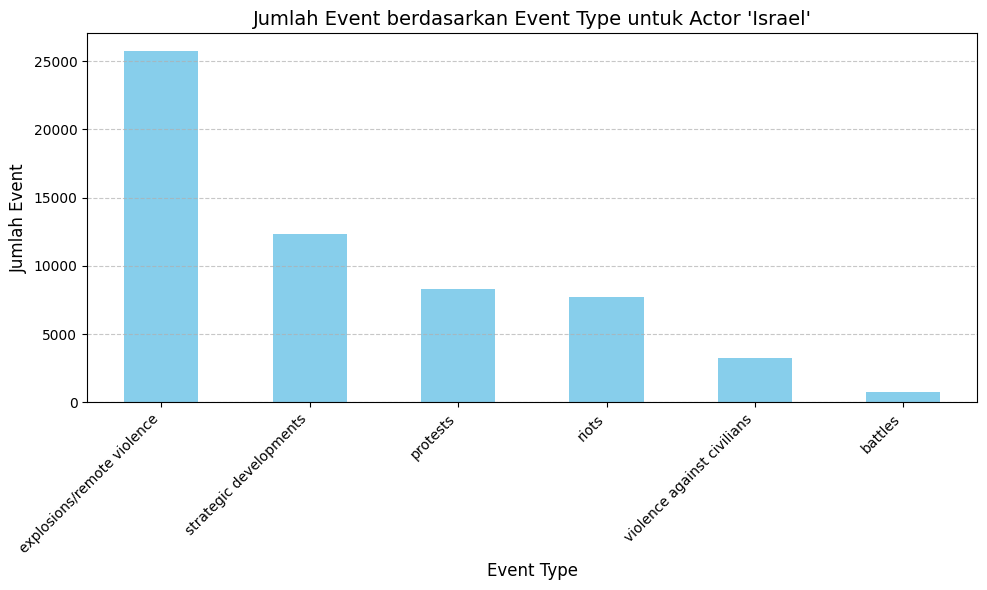

In [ ]:
from pyspark.sql.functions import col, lower
import matplotlib.pyplot as plt

# 1. Filter data berdasarkan actor yang mengandung "israel"
filtered_df = df.filter(lower(col("actor1")).like("%israel%"))

# 2. Konversi DataFrame Spark ke Pandas untuk visualisasi
filtered_pd = filtered_df.toPandas()

# 3. Visualisasi jumlah event berdasarkan jenis event
plt.figure(figsize=(10, 6))
event_counts = filtered_pd['event_type'].value_counts()
event_counts.plot(kind='bar', color='skyblue')

plt.title("Jumlah Event berdasarkan Event Type untuk Actor 'Israel'", fontsize=14)
plt.xlabel("Event Type", fontsize=12)
plt.ylabel("Jumlah Event", fontsize=12)
plt.xticks(rotation=45, ha="right")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()

# 4. Tampilkan plot
plt.show()


#Filter berdasarkan sasaran warga sipil

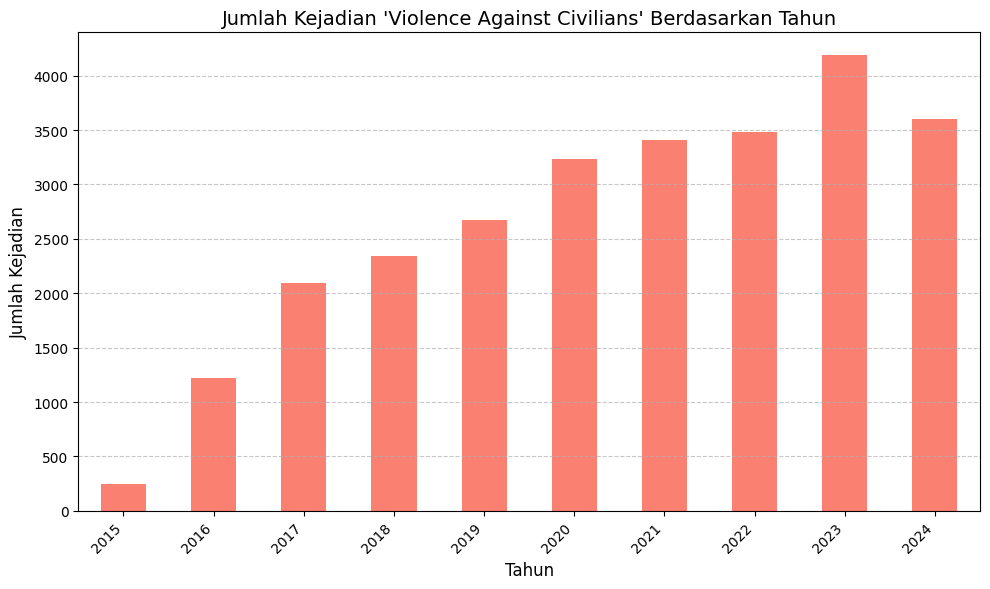

In [ ]:
from pyspark.sql.functions import col, lower
import matplotlib.pyplot as plt

# 1. Filter data berdasarkan event_type 'violence against civilians'
filtered_df = df.filter(lower(col("event_type")) == "violence against civilians")

# 2. Konversi DataFrame Spark ke Pandas untuk visualisasi
filtered_pd = filtered_df.toPandas()

# 3. Visualisasi: Jumlah kejadian berdasarkan tahun
plt.figure(figsize=(10, 6))
event_year_counts = filtered_pd['year'].value_counts().sort_index()
event_year_counts.plot(kind='bar', color='salmon')

plt.title("Jumlah Kejadian 'Violence Against Civilians' Berdasarkan Tahun", fontsize=14)
plt.xlabel("Tahun", fontsize=12)
plt.ylabel("Jumlah Kejadian", fontsize=12)
plt.xticks(rotation=45, ha="right")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()

# 4. Tampilkan plot
plt.show()


In [ ]:
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.regression import LinearRegression
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.sql.functions import col

# 1. Pilih fitur yang relevan untuk prediksi
# Misalnya: latitude, longitude, year, time_precision
features = ["latitude", "longitude", "year", "time_precision"]

# Pastikan kolom 'fatalities' adalah numerik
df = df.withColumn("fatalities", col("fatalities").cast("double"))

# 2. VectorAssembler untuk menggabungkan fitur menjadi satu vektor
assembler = VectorAssembler(inputCols=features, outputCol="features")
df = assembler.transform(df)

# 3. Split data menjadi training dan testing (70% training, 30% testing)
train_data, test_data = df.randomSplit([0.7, 0.3], seed=42)

# 4. Inisialisasi dan latih model regresi linier
lr = LinearRegression(featuresCol="features", labelCol="fatalities", predictionCol="prediction")
model = lr.fit(train_data)

# 5. Prediksi menggunakan testing data
predictions = model.transform(test_data)

# 6. Evaluasi model menggunakan Mean Absolute Error (MAE) dan Root Mean Squared Error (RMSE)
evaluator_mae = RegressionEvaluator(labelCol="fatalities", predictionCol="prediction", metricName="mae")
evaluator_rmse = RegressionEvaluator(labelCol="fatalities", predictionCol="prediction", metricName="rmse")

mae = evaluator_mae.evaluate(predictions)
rmse = evaluator_rmse.evaluate(predictions)

# 7. Tampilkan hasil evaluasi
print(f"Mean Absolute Error (MAE): {mae}")
print(f"Root Mean Squared Error (RMSE): {rmse}")

# 8. Tampilkan beberapa prediksi
predictions.select("latitude", "longitude", "year", "time_precision", "fatalities", "prediction").show(10)


Mean Absolute Error (MAE): 1.562951316339935
Root Mean Squared Error (RMSE): 4.520772677031077
+--------+---------+----+--------------+----------+------------------+
|latitude|longitude|year|time_precision|fatalities|        prediction|
+--------+---------+----+--------------+----------+------------------+
| 25.0657|  55.1713|2022|             1|       0.0|0.7075211209426016|
| 24.4667|  54.3667|2022|             1|       0.0|0.7331704015180094|
| 24.4667|  54.3667|2022|             1|       0.0|0.7331704015180094|
| 24.4667|  54.3667|2021|             1|       0.0|0.9298393291652474|
|  24.493|   54.407|2018|             1|       0.0|1.5186896399966372|
| 25.0657|  55.1713|2019|             1|       0.0|1.2975279038843723|
| 26.2259|  50.5452|2017|             1|       0.0|1.6788709675035989|
| 26.1547|  50.6206|2021|             1|       0.0|0.8942018357973325|
|   26.22|  50.5359|2021|             1|       0.0|0.8924562737532824|
| 26.2279|  50.5857|2021|             1|       0.0|0.

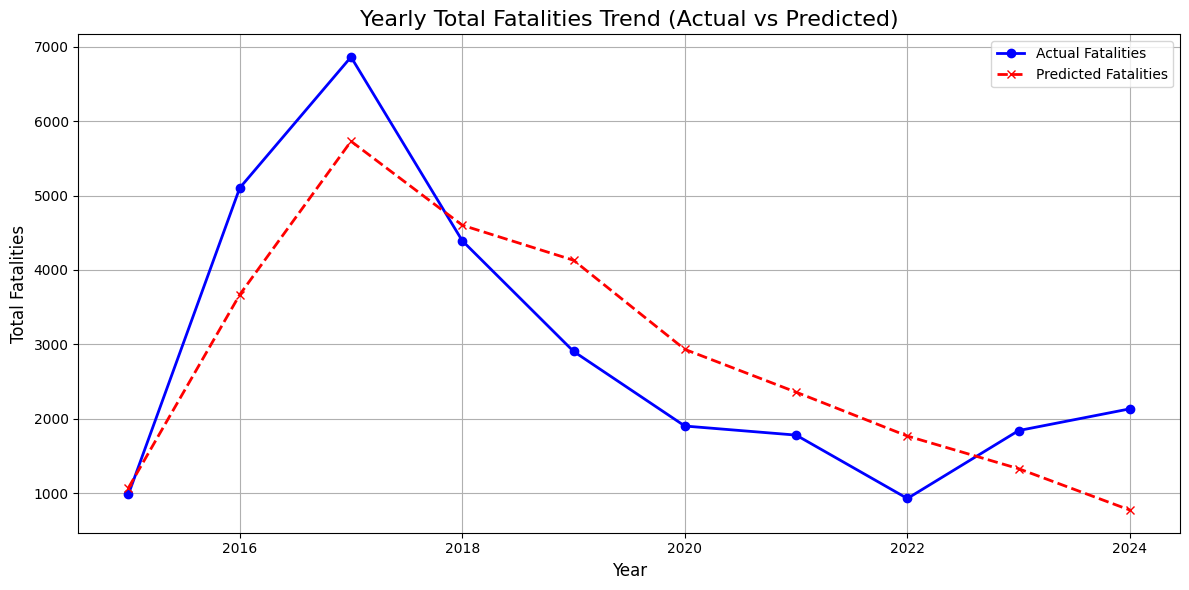

In [ ]:
import matplotlib.pyplot as plt
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.regression import LinearRegression
from pyspark.ml import Pipeline

# 1. Pisahkan data menjadi training dan testing
(training_data, testing_data) = predictions.randomSplit([0.8, 0.2], seed=1234)

# 2. Menghapus kolom 'features' dan 'prediction' jika sudah ada di DataFrame
if 'features' in training_data.columns:
    training_data = training_data.drop('features')
if 'features' in testing_data.columns:
    testing_data = testing_data.drop('features')
if 'prediction' in training_data.columns:
    training_data = training_data.drop('prediction')
if 'prediction' in testing_data.columns:
    testing_data = testing_data.drop('prediction')

# 3. Siapkan fitur yang relevan untuk model (misalnya, tahun dan faktor lainnya)
feature_columns = ["year", "time_precision"]  # Anda dapat menambahkan kolom fitur lainnya jika perlu

# 4. Siapkan assembler untuk menggabungkan fitur menjadi satu kolom fitur
assembler = VectorAssembler(inputCols=feature_columns, outputCol="features")

# 5. Inisialisasi model Linear Regression
lr = LinearRegression(labelCol="fatalities", featuresCol="features")

# 6. Siapkan pipeline dengan assembler dan model
pipeline = Pipeline(stages=[assembler, lr])

# 7. Latih model menggunakan training data
model = pipeline.fit(training_data)

# 8. Prediksi menggunakan data testing
predictions_testing = model.transform(testing_data)

# 9. Ambil data tahun dan jumlah korban (fatalities) dari data testing
predictions_test_pd = predictions_testing.select("year", "fatalities", "prediction").toPandas()

# 10. Kelompokkan data berdasarkan tahun dan hitung jumlah total fatalities per tahun
yearly_actual = predictions_test_pd.groupby("year")["fatalities"].sum().reset_index()
yearly_predicted = predictions_test_pd.groupby("year")["prediction"].sum().reset_index()

# 11. Plot grafik garis untuk jumlah korban per tahun
plt.figure(figsize=(12, 6))

# Plot jumlah total fatalities aktual per tahun
plt.plot(yearly_actual["year"], yearly_actual["fatalities"], label="Actual Fatalities", color="blue", marker="o", linestyle='-', linewidth=2)

# Plot jumlah total fatalities prediksi per tahun
plt.plot(yearly_predicted["year"], yearly_predicted["prediction"], label="Predicted Fatalities", color="red", marker="x", linestyle='--', linewidth=2)

# Tambahkan detail grafik
plt.title("Yearly Total Fatalities Trend (Actual vs Predicted)", fontsize=16)
plt.xlabel("Year", fontsize=12)
plt.ylabel("Total Fatalities", fontsize=12)

# Menambahkan grid dan legend
plt.grid(True)
plt.legend()

# 12. Tampilkan grafik
plt.tight_layout()
plt.show()
